In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import collections
import re
from d2l import torch as d2l


In [2]:
batch_size, num_steps = 200, 35

In [3]:
data = d2l.TimeMachine(batch_size, num_steps)
train_iter:DataLoader = data.get_dataloader(train=True)
vocab = data.vocab

## ONE_HOT

In [4]:
F.one_hot(torch.tensor([0, 2]), len(data.vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

Data shape (batch size, time step)

In [5]:
X = torch.arange(10).reshape((2, 5))
# Exchange of shape meanings. To (num_steps, batch_size)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### Initializing the model parameters of a sequential neural network model

The `num_hiddens` is not the number of hidden elements, 
but the dimension of a single hidden element.
The `num_inputs` is not the number of inputs elements, 
but the dimension of a single input element

In [6]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Update the H_t
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Update the o_t(q_t)
    W_ho = normal((num_hiddens, num_outputs))
    b_o = torch.zeros(num_outputs, device=device)

    # SET GRAD
    params = [W_xh, W_hh, b_h, W_ho, b_o]
    for param in params:
        param.requires_grad_(True)
    return params

In [7]:
# The first h state
# The return value is tuple, in order to convenience lstm
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [8]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_ho, b_o = params
    H, = state
    outputs = []
    for X in inputs:
        # Hidden state
        H = torch.tanh(torch.mm(X, W_xh)
                       + torch.mm(H, W_hh)
                       + b_h)
        # Output
        Y = torch.mm(H, W_ho) + b_o
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [9]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

## Check that the output has the correct shape

In [10]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(),
                      get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)

Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [11]:
# The `prefix` is input str
# The `num_preds` is the number of predictions to be made
def predict_ch8(prefix, num_preds, net: RNNModelScratch, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1, 1)

    # Update the hidden state to the place to be predicted
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        # append truth ground
        outputs.append(vocab[y])

    # 
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller mqxuvbbqxu'

### Gradient scaling

In [12]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(
        sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [13]:
# Define a function to train a model with only one iteration cycle
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train the model for one iteration cycle"""
    # Initialize hidden states and timers
    state, timer = None, d2l.Timer()
    # Initialize accumulators for metrics to calculate losses and sample sizes
    metric = d2l.Accumulator(2)
    # Iterate through each batch of data in the training iterator
    for X, Y in train_iter:
        # If the hidden state is null or using a random iterator
        if state is None or use_random_iter:
            # Initialize the hidden state, the batch size is the number of rows of X, 
            # and the device is the specified device
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # If net is an instance of nn.Module and the hidden state is not of the tuple type
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # Calculation diagram for separating hidden states
                state.detach_()
            else:
                # For each element in the hidden state
                for s in state:
                    # Separation of computational graphs of hidden states 
                    # for reducing memory footprint and speeding up computation
                    s.detach_()
        # Transpose and flatten the target sequence Y into a one-dimensional tensor
        y = Y.T.reshape(-1)
        # Move the input sequence and target sequence to the specified devices
        X, y = X.to(device), y.to(device)
        # Forward propagation computation using the input sequence and 
        # the hidden state to get the predicted value and the updated hidden state
        y_hat, state = net(X, state)
        # Calculation of the loss between the predicted value and the target value
        l = loss(y_hat, y.long()).mean()
        # If you use PyTorch's built-in optimizer
        if isinstance(updater, torch.optim.Optimizer):
            # Clear the gradient in the optimizer
            updater.zero_grad()
            # Backpropagation computes the gradient
            l.backward()
            # crop gradient
            grad_clipping(net, 1)
            # Perform a one-step parameter update
            updater.step()
        else:
            # Backpropagation computes the gradient
            l.backward()
            # crop gradient
            grad_clipping(net, 1)
            # Execute a customized parameter update function
            updater(batch_size=1)
        # Cumulative loss and sample size
        metric.add(l * y.numel(), y.numel())
    # Calculate the average loss and the number of samples processed per second, 
    # return the exponential form of the average loss (with e as the base) 
    # and the rate of sample processing per second
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
# The training function supports recurrent neural network models implemented from scratch 
# or using high-level APIs
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """training model"""
    # Define the loss function as the cross-entropy loss
    loss = nn.CrossEntropyLoss()
    # Creation of animation objects for visualizing loss changes during training
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    # If the model is an instance of nn.Module
    if isinstance(net, nn.Module):
        # Parameter update using PyTorch's optimizer SGD
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # Otherwise, use a customized gradient descent function for parameter updates
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # Define a prediction function to generate a new sequence of characters after a given prefix
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Iterate through each iteration cycle
    for epoch in range(num_epochs):
        # Train for one iteration cycle 
        # and return the perplexity and the rate of sample processing per second
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        # Generated every 10 iterations
        if (epoch + 1) % 10 == 0:
            # Prints a new sequence of characters prefixed with 'time traveller'.
            print(predict('time traveller'))
            # Visualize the current iteration cycle's perplexity by adding it to the animation
            animator.add(epoch + 1, [ppl])
    # Print final perplexity and sample processing speed per second
    print(f'perplexity {ppl:.1f}, {speed:.1f} token/s {str(device)}')
    # Generate and print a new sequence of characters prefixed with 'time traveller'.
    print(predict('time traveller'))
    # Generate and print a new sequence of characters prefixed with 'traveller'
    print(predict('traveller'))

perplexity 1.4, 526988.8 token/s cuda:0
time traveller smiled are you sure we can move freely in space r
traveller it s against reason said filby what reason said t


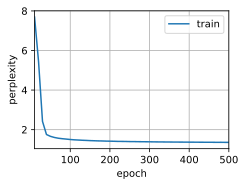

In [15]:
# Now we can train the recurrent neural network model
# Setting the number of iteration cycles and learning rate
num_epochs, lr = 500, 1
# The training function is called to train the model, 
# using the training data iterator, vocabulary, learning rate, 
# number of iteration cycles, and device information as inputs
train_ch8(net, train_iter, data.vocab, lr, num_epochs, d2l.try_gpu())